# **Verifiable Image Classification using SVM**

### Loading Dataset

In [5]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_and_resize_images(folder, target_size=(64, 64)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return images

folder_path = '../../Dataset/new_data'
images = load_and_resize_images(folder_path, target_size=(64, 64))
flat_images = [img.flatten() for img in images]

image_matrix = np.vstack(flat_images)


### Principle Component Analysis for feature extraction

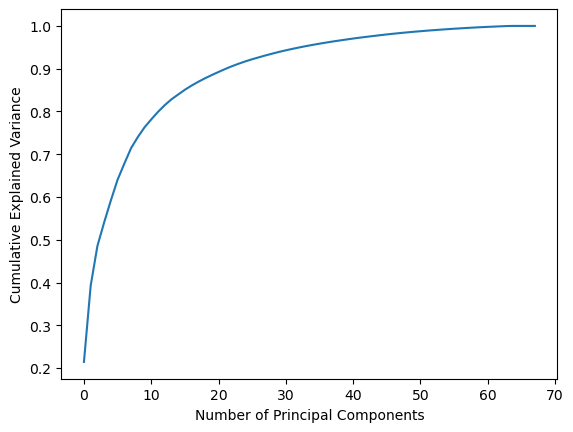

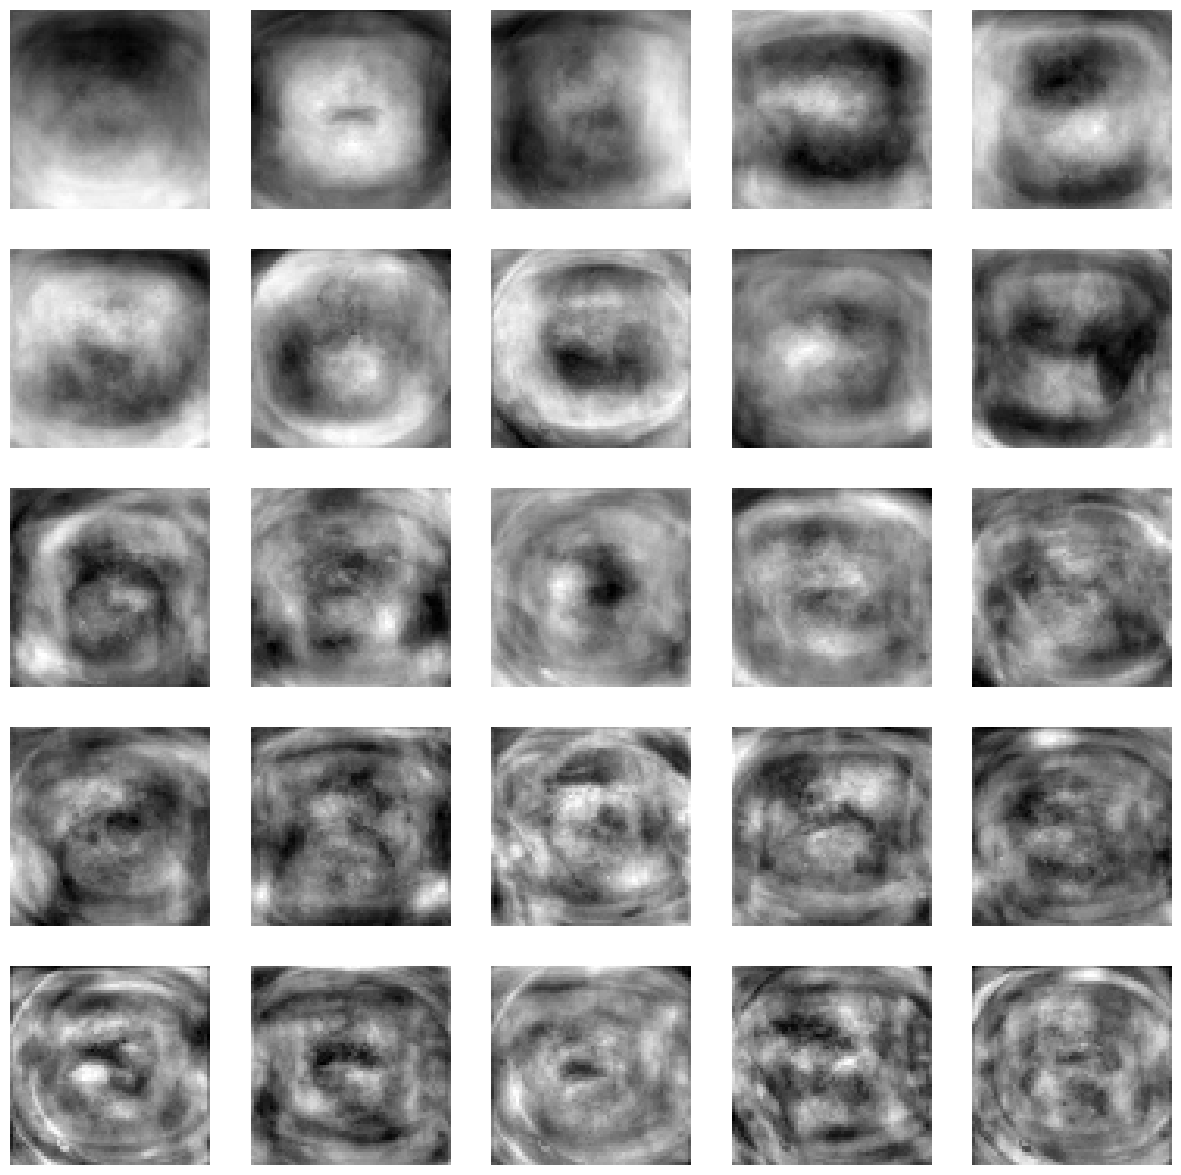

In [14]:
mean_vector = np.mean(image_matrix, axis=0)
standardized_images = image_matrix - mean_vector

# Applying PCA
pca = PCA()
pca.fit(standardized_images)



plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# the number of principal components based on the plot
num_components = 25


pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(standardized_images)


num_rows = 5
num_cols = num_components // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_rows):
    for j in range(num_cols):
        # Calculate the index in the flattened PCA components array
        index = i * num_cols + j

        # Reshape the flattened PCA component to a 2D array (eigenface)
        eigenface = pca.components_[index, :].reshape((64, 64))

        # Display the eigenface in the subplot
        axes[i, j].imshow(eigenface, cmap='gray')
        axes[i, j].axis('off')

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1

X = np.hstack((X, np.ones((X.shape[0], 1))))

X_train, y_train = X[:100, :], y[:100]
X_test, y_test = X[100:, :], y[100:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 3) (100,) (50, 3) (50,)


### **Loss function, gradient and Weight init** 

le is on the correct side of the margin, the loss is 0.

$\text{Loss Function}$  = $ \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - y_i \times (\mathbf{w} \cdot \mathbf{x}_i)) + C \times \frac{1}{2} \times \mathbf{w} \cdot \mathbf{w}$

$\text{Gradient}$  =  $\frac{1}{N} \sum_{i=1}^{N} \left( -y_i \times \mathbf{x}_i \text{ (si } y_i \times (\mathbf{w} \cdot \mathbf{x}_i) < 1 \text{) } \right) + C \times \mathbf{w}$

For the purposes of this tutorial, we initialize $\mathbf{w}$ as an array of $\mathbf{0's}$

In [4]:
def loss_function(w, X, y, C):  
    hinge_loss = np.maximum(0, 1 - y * np.dot(X, w)) 
    regularization_term = 0.5 * np.dot(w, w)  # Regularización L2 ###
    total_loss = np.mean(hinge_loss) + C * regularization_term ###
    return total_loss

def loss_gradient(w, X, y, C):     
    mask = (y * (np.dot(X, w))) < 1    #<1
    gradient = (-np.dot(mask * y, X) / len(y)) +  C*w
    return gradient

losses = []
w = np.zeros(3)

In [5]:
learning_rate = 0.01
num_epochs = 100
C = 1

### **Training** 

In [6]:
for epoch in range(num_epochs):
    loss = loss_function(w,X_train, y_train, C)
    losses.append(loss)

    if epoch % 25 == 0 or epoch  == 99:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

    gradient_w = loss_gradient(w, X_train, y_train,C)
    w -= learning_rate * gradient_w

Epoch 0, Loss: 1.0000
Epoch 25, Loss: 0.5300
Epoch 50, Loss: 0.4594
Epoch 75, Loss: 0.4238
Epoch 99, Loss: 0.4092


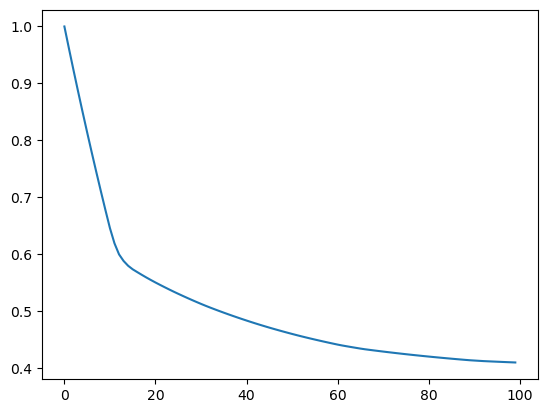

In [7]:
plt.plot(losses)

After training the model and observing the decrease of the loss function, we evaluate its performance on both the training and test data. We will calculate the accuracy and display the final loss on the training data. In our case, the weights $\mathbf{w}$ and the accuracies will be the values against which we compare the SVM implementation in Cairo with Orion.

###  **Evaluate model on training data** 

In [8]:
def predict(X, w):
    return np.sign(np.dot(X, w))

predictions = predict(X_train, w)
final_loss = loss_function(w, X_train, y_train,C)

print("Accuracy: {}".format((predictions == y_train).mean()))
print("Final loss: {}".format(final_loss))

Accuracy: 0.99
Final loss: 0.4089273002134721


###  **Evaluate model on test data**

In [9]:
predictions = predict(X_test, w)

print("Accuracy: {}".format((predictions == y_test).mean()))

Accuracy: 0.98


In [10]:
w

array([ 0.36715632, -0.35873007,  0.12536368])

Next, we will visualize the obtained hyperplane, determined by $\mathbf{w} = (0.367, -0.358, 0.125)$ and the way it separates the classes in the test data.

The equation of the line obtained is $\mathbf{Y} = 1.023\mathbf{X} + 0.349$

### **Generating Cairo files**


In [12]:
def decimal_to_fp16x16(num):
    whole_num = int(num)
    fractional_part = int((num - whole_num) * 65536)
    fp_number = (whole_num << 16) + fractional_part
    return fp_number

In [13]:
import os

In [20]:
os.makedirs("src/generated", exist_ok=True)

In [21]:
tensor_name = ["X_train", "Y_train", "X_test", "Y_test"]

def generate_cairo_files(data, name):
    
    with open(os.path.join('src', 'generated', f"{name}.cairo"), "w") as f:
        f.write(
            "use array::ArrayTrait;\n" +
            "use orion::operators::tensor::{Tensor, TensorTrait, FP16x16Tensor};\n" +
            "use orion::numbers::{FixedTrait, FP16x16, FP16x16Impl};\n" +
            "\n" + f"fn {name}() -> Tensor<FP16x16>" + "{\n\n" + 
            "let mut shape = ArrayTrait::new();\n"
        )
        for dim in data.shape:
            f.write(f"shape.append({dim});\n")
    
        f.write("let mut data = ArrayTrait::new();")
        for val in np.nditer(data.flatten()):
            f.write(f"data.append(FixedTrait::new({abs(int(decimal_to_fp16x16(val)))}, {str(val < 0).lower()}));\n")
        f.write(
            "let tensor = TensorTrait::<FP16x16>::new(shape.span(), data.span());\n" +
            "return tensor;\n}"
        )

with open(f"src/generated.cairo", "w") as f:
    for n in tensor_name:
        f.write(f"mod {n};\n")

generate_cairo_files(X_train, "X_train")
generate_cairo_files(X_test, "X_test")
generate_cairo_files(y_train, "Y_train")
generate_cairo_files(y_test, "Y_test")

 **Convert hyperparameters to FP16x16**


In [22]:
print(decimal_to_fp16x16(learning_rate))
print(decimal_to_fp16x16(C))
print(decimal_to_fp16x16(num_epochs))

655
65536
6553600


 **Get an estimate for the initial and final loss value, and final weights in FP16x16**  

In [23]:
w = np.array([decimal_to_fp16x16(w[0]),
decimal_to_fp16x16(w[1]),
decimal_to_fp16x16(w[2])])

print("Initial loss: {}".format(decimal_to_fp16x16(losses[0])))
print("Final loss: {}".format(decimal_to_fp16x16(final_loss)))
print("Weights: {}".format(w))

Initial loss: 65536
Final loss: 26799
Weights: [ 24061 -23509   8215]
